In [1]:
%config Completer.use_jedi = False

In [2]:
# data wrangling
import pandas as pd
import numpy as np
import pickle
from collections import Counter
# scraping
import json
import requests
import re
from bs4 import BeautifulSoup
import tabula
# clustering
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
# plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium

In [3]:
%matplotlib inline

In [4]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## extract socio-demographic data

### *credits: Istat - Italian institute of statistics* 
www.istat.it

In [23]:
file = 'https://www.istat.it/it/files//2017/01/C-allegato-statistico24_01_17_REV.pdf'
tables = tabula.read_pdf(file, pages = "18-23", multiple_tables = True)

col_names = ['Name', 'Surface', 'Population','Pop0-14', 'Foreigners','Centrality Index', 'Old Age Index', 'Foreigner Rate', 'School Dropout Rate','Unemployment Rate', 'Neet Rate','Economic Discomfort Index', 'Cultural Employees Index', 'Sections Number']
urban_zones_df = pd.DataFrame(columns=col_names)

wrong_col = 'Unnamed: 0'
for i, df in enumerate(tables):
    if wrong_col in df.columns:
        df = df.drop([wrong_col], axis=1)
    df.columns = col_names
    urban_zones_df = urban_zones_df.append(df[5:], ignore_index = True)

urban_zones_df = urban_zones_df[:-3]
urban_zones_df.head()

In [24]:
# format conversion
urban_zones_df['Surface'] = urban_zones_df['Surface'].str.replace(',','.').astype(float)
urban_zones_df['Population'] = urban_zones_df['Population'].str.replace('.','').astype(int)
urban_zones_df['Pop0-14'] = urban_zones_df['Pop0-14'].str.replace('.','').astype(int)
urban_zones_df['Foreigners'] = urban_zones_df['Foreigners'].str.replace('.','').astype(int)
urban_zones_df['Centrality Index'] = urban_zones_df['Centrality Index'].str.replace(',','.').astype(float)
urban_zones_df['Old Age Index'] = urban_zones_df['Old Age Index'].str.replace(',','.').astype(float)
urban_zones_df['Foreigner Rate'] = urban_zones_df['Foreigner Rate'].str.replace(',','.').astype(float)
urban_zones_df['School Dropout Rate'] = urban_zones_df['School Dropout Rate'].str.replace(',','.').astype(float)
urban_zones_df['Unemployment Rate'] = urban_zones_df['Unemployment Rate'].str.replace(',','.').astype(float)
urban_zones_df['Neet Rate'] = urban_zones_df['Neet Rate'].str.replace(',','.').astype(float)
urban_zones_df['Economic Discomfort Index'] = urban_zones_df['Economic Discomfort Index'].str.replace(',','.').astype(float)
urban_zones_df['Cultural Employees Index'] = urban_zones_df['Cultural Employees Index'].str.replace(',','.').astype(float)
urban_zones_df = urban_zones_df.drop(['Sections Number'],axis=1)

In [56]:
urban_zones_df[urban_zones_df['Economic Discomfort Index'].isnull()]

NameError: name 'urban_zones_df' is not defined

In [26]:
urban_zones_df[urban_zones_df['Economic Discomfort Index'].isnull()]['Population'].sum()

6421

In [27]:
urban_zones_df = urban_zones_df.dropna()

## extract geografical coordinates
### *credits*: https://www.mapparoma.info/zone-urbanistiche/

In [30]:
shapefile = "zip:///home/michele/battle_of_neighborhoods_w1/ZU_shapefile.zip"
gdf = gpd.read_file(shapefile)

gdf = gdf.to_crs(epsg=4326)

# tweaking zone names
gdf['Name'].where(gdf['Name']!='Centro Direz. Centocelle','Centro Direzionale Centocelle',inplace=True)
gdf['Name'].where(gdf['Name']!='Grotta Rossa Est','Grottarossa Est',inplace=True)
gdf['Name'].where(gdf['Name']!='Grotta Rossa Ovest','Grottarossa Ovest',inplace=True)
gdf['Name'].where(gdf['Name']!='Mezzocamino','Mezzocammino',inplace=True)
gdf['Name'].where(gdf['Name']!='S. Maria della Pieta','S. Maria della Pietà',inplace=True)
gdf['Name'].where(gdf['Name']!='Universita','Università',inplace=True)

In [33]:
# calculate centroids
zones_centroids = gdf.centroid

centroids_lon = [c.coords.xy[0][0] for c in zones_centroids]
centroids_lat = [c.coords.xy[1][0] for c in zones_centroids]

urban_zones_coords = pd.DataFrame(zip(gdf['Name'], centroids_lat, centroids_lon), columns = ['Name', 'Latitude', 'Longitude'])


# join dataframes
zones_df = urban_zones_df.merge(urban_zones_coords, how='inner', left_on='Name', right_on='Name')

## extract venues

In [34]:
# Foursquare credentials and constants
CLIENT_ID = 'ELCGO4JTDN3CY4NULPEECJK2GBOEG5QY3HV2VZBKVQV2JFWM' # your Foursquare ID
CLIENT_SECRET = 'GIZWPHWRTEMWAPRMK0FBATZZI2AXJCOQ54FUPDI05LL0FAO0' # your Foursquare Secret
ACCESS_TOKEN = '23AO4TFOWEVEPLDSO2VRJY334SAAFJ3E1QNIH30AFYIHAMHL' # your FourSquare Access Token
VERSION = '20210221'
LIMIT = 200
RADIUS = 1000


In [35]:
# create a dataframe of macro categories for venues categories aggregation
url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}&limit=100' \
      .format(CLIENT_ID, CLIENT_SECRET, VERSION)
results = requests.get(url).json()
macro_categories_df = pd.json_normalize(results['response']['categories'])

In [36]:
# function for expanding the sub-categories
def expand(l, c, d):
    d[c] = c #always add macro as sub-cat
    for i in l:
        if len(i['categories']) > 0:
            d[i['name']] = c
            expand(i['categories'], c, d)
        else:
            d[i['name']] = c #print("".format(i['name']))

In [37]:
# dictionary of sub-cats with macro category
macros = {}
for categories, name in zip(macro_categories_df['categories'], macro_categories_df['name']):
    expand(categories, name, macros)

In [ ]:
venues_df = pd.DataFrame(columns=['name','categories', 'macros'])
for name, lat, lon in zip(zones_df['Name'], zones_df['Latitude'], zones_df['Longitude']):
    print(name)
    dict_row = {}
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&sortByDistance=1' \
      .format(CLIENT_ID, CLIENT_SECRET, lat, lon, VERSION, RADIUS, LIMIT)
    results = requests.get(url).json()
    items = results['response']['groups'][0]['items']
    categories_list = [item['venue']['categories'][0]['name'] for item in items]
    dict_row['name'] = name
    dict_row['categories'] = Counter(categories_list)
    macros_list = [macros[cat] for cat in categories_list]
    dict_row['macros'] = Counter(macros_list)
    venues_df = venues_df.append(dict_row, ignore_index = True)

In [42]:
venues_macro_df = venues_df[['name']].copy()

for macro in macro_categories_df['name']:
    venues_macro_df[macro] = 0.0
venues_macro_df = venues_macro_df.set_index('name')

for name, macros in zip(venues_df['name'], venues_df['macros']):
    for cat, cnt in macros.items():
        venues_macro_df.loc[name, cat] = cnt

venues_macro_df['Total Venues'] = venues_macro_df.apply(sum, axis = 1)

In [44]:
zones_df = zones_df.rename({'Name':'name'}, axis=1)
zones_df.set_index(['name'], inplace=True)

final_df = pd.concat([zones_df, venues_macro_df],axis=1,join='inner')

### compute venues data as number of venues per 1000 residents

In [47]:
venues_features = final_df.columns[14:25]

for feature in venues_features:
    final_df[feature] = 1000 * final_df[feature] / final_df['Population'] 

### compute Pop0-14 as Index per 1000 residents

final_df['Pop0-14'] = 1000 * final_df['Pop0-14'] / final_df['Population']

## Exploratory data analysis

### explore socio-demographic features

In [52]:
social_features = [f for f in final_df.columns if f not in venues_features]
social_features.remove('Latitude')
social_features.remove('Longitude')

socio_df = final_df[social_features]

socio_df.describe()[1:]

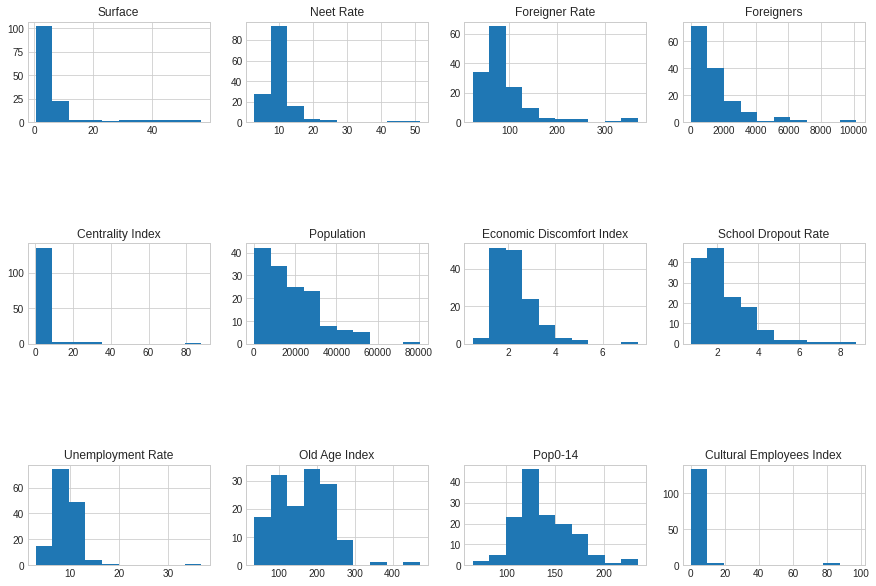

In [53]:
plt.style.use('seaborn-whitegrid')
fig, axes = plt.subplots(figsize=(15,10), nrows=3, ncols=4, gridspec_kw={'hspace':1.2})
for n, feature in enumerate(socio_df.columns):
    i = (n % 3)
    j = (n % 4)
    axes[i,j].hist(socio_df[feature])
    axes[i,j].set_title(feature)

In [54]:
geo_socio_df = gdf.merge(socio_df, how='inner', left_on='Name', right_index=True)

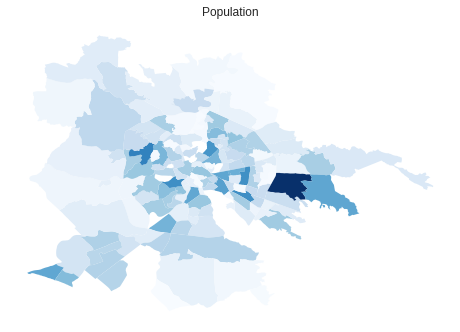

In [55]:
plt.style.use('seaborn-white')
cmap='Blues'
fig = plt.figure(figsize=(8,6))
ax = plt.subplot()
geo_socio_df.plot(column='Population',cmap=cmap, ax=ax)
ax.set_title('Population')
ax.set_axis_off();

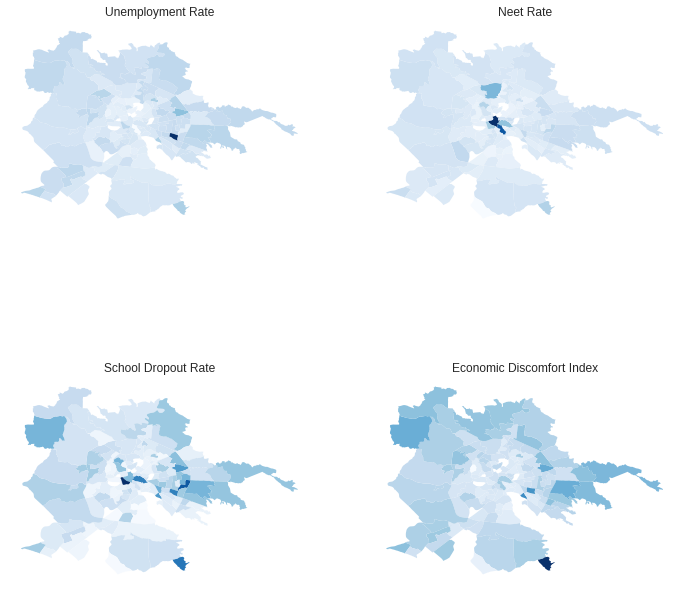

In [56]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(12,12))
for n, feature in enumerate(['Unemployment Rate', 'Neet Rate', 'School Dropout Rate', 'Economic Discomfort Index']):
    i = 0 if n < 2 else 1
    j = 0 if n % 2 == 0 else 1
    geo_socio_df.plot(column=feature,cmap=cmap, ax=axes[i,j])
    axes[i,j].set_title(feature)
    axes[i,j].set_axis_off()


### Explore venues features

In [57]:
venues_eda_df = final_df[venues_features]

venues_eda_df.describe()

,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Total Venues
count,144.00,144.00,144.00,144.00,144.00,144.00,144.00,144.00,144.00,144.00,144.00
mean,0.39,0.00,0.00,2.93,0.54,0.69,0.07,0.00,0.48,0.58,5.67
std,1.78,0.00,0.00,10.79,2.18,2.30,0.33,0.01,1.02,2.05,19.14
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.20,0.00,0.05,0.00,0.00,0.08,0.00,0.51
50%,0.00,0.00,0.00,0.53,0.04,0.16,0.00,0.00,0.18,0.08,1.15
75%,0.10,0.00,0.00,1.69,0.24,0.38,0.00,0.00,0.38,0.38,3.31
max,14.90,0.05,0.00,108.01,20.48,18.62,3.72,0.07,9.31,20.55,186.22


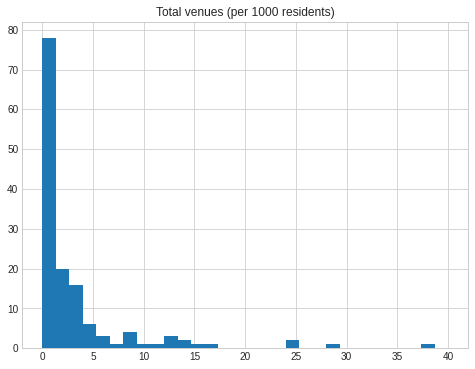

In [58]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(8,6))
ax = plt.subplot()
ax.hist(venues_eda_df['Total Venues'], bins=30, range=(0,40))
ax.set_title('Total venues (per 1000 residents)');

In [59]:
geo_venues_df = gdf.merge(venues_eda_df, how='inner', left_on='Name', right_index=True)

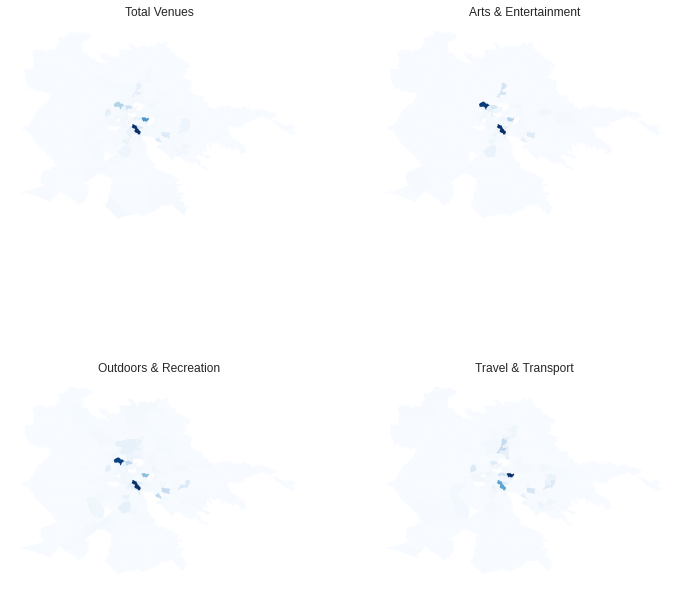

In [60]:
plt.style.use('seaborn-white')
cmap='Blues'
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(12,12))
for n, feature in enumerate(['Total Venues', 'Arts & Entertainment', 'Outdoors & Recreation', 'Travel & Transport']):
    i = 0 if n < 2 else 1
    j = 0 if n % 2 == 0 else 1
    geo_venues_df.plot(column=feature,cmap=cmap, ax=axes[i,j])
    axes[i,j].set_title(feature)
    axes[i,j].set_axis_off()

## Clustering

### for clustering, remove the following features:
- latitude
- longitude
- surface

### normalize features via Standard scaling (X - $\mu$) / $\sigma$ 

In [62]:
# remove features
clustering_df = final_df.drop(['Latitude','Longitude','Surface', 'Foreigners'],axis=1)

# feature standard-scaling
StdScaler = StandardScaler()
X = StdScaler.fit_transform(clustering_df)

In [63]:
# perform clustering with k = 1..10 and calculate inertia and silhouette
silhouettes = {}
ssqs = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X)
    silhouette = silhouette_score(X, kmeans.labels_) if k > 1 else np.nan
    ssq = kmeans.inertia_
    silhouettes[k] = silhouette
    ssqs[k] = ssq

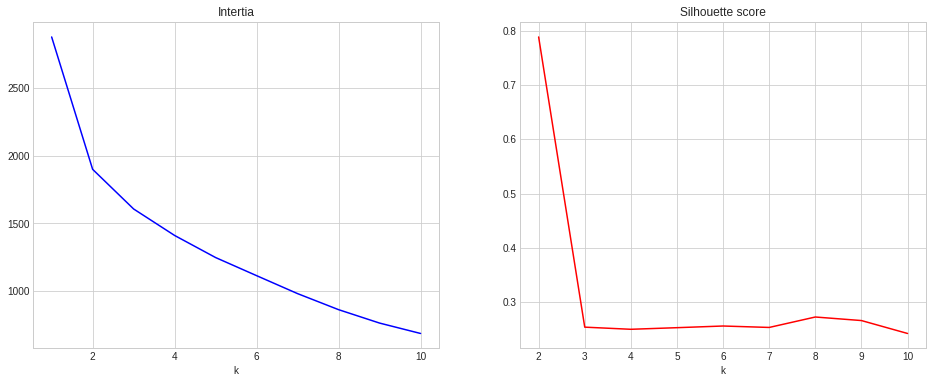

In [64]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize = (16,6))

ax1 = plt.subplot(121)
ax1.plot(list(ssqs.keys()), list(ssqs.values()), c='b', label='Inertia')
ax1.set_title('Intertia')
ax1.set_xlabel('k')
#ax1.plot(4,ssqs[4],'o',markersize=10)

ax2 = plt.subplot(122)
ax2.plot(list(silhouettes.keys()), list(silhouettes.values()), c='r', label='Silhouette')
ax2.set_title('Silhouette score')
ax2.set_xlabel('k')

plt.show()

In [69]:
kmeans = KMeans(n_clusters=3,n_init=30, max_iter=3000, tol=0.00001)
kmeans.fit(X)
clusters = kmeans.labels_

# assign cluster labels to observations
final_df['Cluster'] = clusters

In [70]:
final_df.Cluster.value_counts().sort_index()

0    60
1    81
2     3
Name: Cluster, dtype: int64

In [74]:
pd.set_option('display.max_columns',None)

clusters_avgs = final_df.groupby('Cluster').mean()

clusters_avgs = clusters_avgs.merge(final_df.Cluster.value_counts(), left_index=True, right_index=True)

clusters_avgs.rename({'Cluster': 'Nr of Zones'}, inplace=True, axis=1)

In [88]:
s.name in ['Surface', 'Pop0-14', 'School Dropout Rate','Unemployment Rate', 'Economic Discomfort Index']

False

In [93]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v and s.name in ['Surface', 'Pop0-14', 'School Dropout Rate','Unemployment Rate', 'Economic Discomfort Index'] else '' for v in is_max ]

In [94]:
clusters_avgs[list(social_features) + ['Total Venues','Nr of Zones']].style.apply(highlight_max)

,Surface,Population,Pop0-14,Foreigners,Centrality Index,Old Age Index,Foreigner Rate,School Dropout Rate,Unemployment Rate,Neet Rate,Economic Discomfort Index,Cultural Employees Index,Total Venues,Nr of Zones
0,14.671667,14715.450000,158.542113,1705.100000,1.855000,107.175000,112.001667,3.256667,10.990000,12.666667,2.898333,3.471667,2.110949,60
1,3.369136,21302.160494,124.350715,1489.506173,2.603704,199.029630,70.206173,1.729630,8.222222,8.213580,1.704938,5.035802,4.075663,81
2,1.633333,680.666667,85.840113,131.666667,50.700000,324.800000,209.066667,2.766667,5.833333,24.866667,2.533333,86.066667,119.732840,3


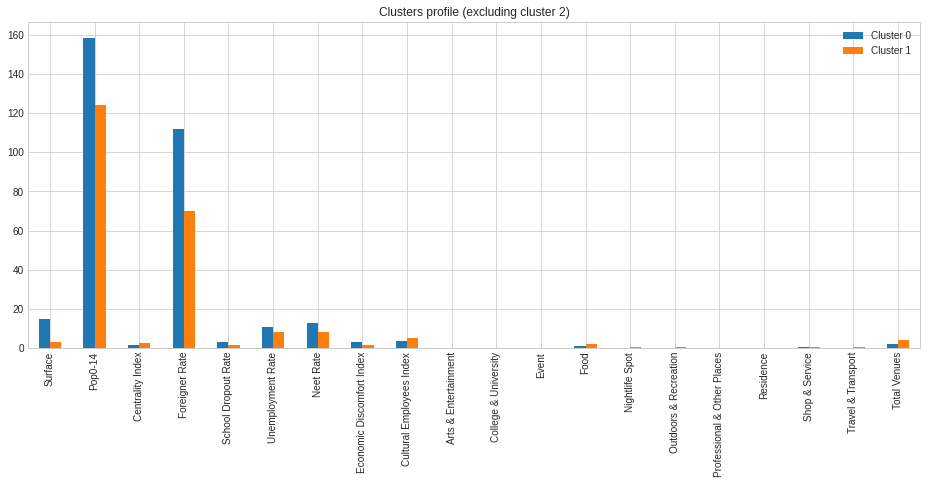

In [95]:
clusters_avgs.loc[[0,1]].drop(['Population', 'Foreigners', 'Latitude', 'Longitude', 'Old Age Index', 'Nr of Zones'],axis=1).transpose().plot(kind='bar',figsize=(16,6))
plt.legend(('Cluster 0', 'Cluster 1'))
plt.title('Clusters profile (excluding cluster 2)');

In [110]:
geo_clusters_df = gdf.merge(final_df[['Cluster']],how='inner',left_on='Name', right_index=True)

clusters_centroids = gpd.GeoDataFrame(zip(geo_clusters_df['Cluster'], geo_clusters_df['geometry'].centroid),columns=['Cluster', 'Centroid']).set_geometry('Centroid')

plt.style.use('seaborn-white')
colors = np.array(['r', 'b', 'w'])
fig = plt.figure(figsize=(10,10))
ax = plt.subplot()
geo_clusters_df.plot(column='Cluster', cmap='OrRd_r', ax=ax)
ax.set_title('Territorial distribution of clusters')
ax.set_axis_off();

In [107]:
final_df.query('Cluster == 0').sort_values(by='Pop0-14', ascending=False).head() \
 [['Surface', 'Population','Pop0-14','Centrality Index', 'School Dropout Rate','Unemployment Rate','Neet Rate','Economic Discomfort Index','Total Venues']]

,Surface,Population,Pop0-14,Centrality Index,School Dropout Rate,Unemployment Rate,Neet Rate,Economic Discomfort Index,Total Venues
name,,,,,,,,,
S. Alessandro,11.40,9856,235.09,0.40,1.40,6.60,8.50,2.40,0.51
Magliana,11.50,3803,223.24,8.30,1.70,5.60,15.40,1.80,2.10
Barcaccia,5.10,10099,220.52,0.30,1.30,7.70,7.60,2.60,0.69
Infernetto,11.50,24356,210.22,0.20,1.10,8.00,9.60,3.10,0.37
Lucrezia Romana,1.70,4451,198.38,1.40,1.30,7.20,7.10,1.60,4.04


In [115]:
recommended_zones = final_df.query('Cluster == 0').sort_values(by='Pop0-14', ascending=False).head().index.values
recommended_df = final_df.loc[recommended_zones]

In [55]:
rome_loc = [41.89, 12.48]
rome_map = folium.Map(location=rome_loc,
                      zoom_start=11, 
                      width=700, height=650)

for lat, lon, name in zip(recommended_df['Latitude'], recommended_df['Longitude'], recommended_df.index):
    folium.Marker(
        location = [lat, lon],
        popup = name
    ).add_to(rome_map)
    
    folium.map.Marker(
    location = [lat, lon-0.02],
    icon=folium.features.DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-size: 11pt">'+name+'</div>',
        )
    ).add_to(rome_map)

    
rome_map

In [58]:
final_df

,Surface,Population,Pop0-14,Foreigners,Centrality Index,Old Age Index,Foreigner Rate,School Dropout Rate,Unemployment Rate,Neet Rate,...,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Total Venues
name,,,,,,,,,,,,,,,,,,,,,
Acilia Nord,9.20,26023,162.97,2008,0.20,100.20,77.20,2.10,12.40,10.90,...,0.00,0.00,0.12,0.00,0.00,0.00,0.00,0.04,0.00,0.15
Acilia Sud,7.10,23640,160.62,1833,0.70,107.30,77.50,2.70,12.00,11.30,...,0.00,0.00,0.34,0.04,0.04,0.00,0.00,0.04,0.00,0.51
Acqua Vergine,11.30,5355,192.90,487,0.80,48.20,90.90,2.20,7.80,10.90,...,0.00,0.00,0.19,0.00,0.00,0.00,0.00,0.00,0.19,0.56
Acquatraversa,1.40,8689,145.70,678,0.30,129.20,78.00,1.10,6.10,7.20,...,0.00,0.00,0.12,0.00,0.58,0.00,0.00,0.12,0.23,1.04
Aeroporto dell' Urbe,4.40,1924,128.38,172,11.00,172.10,89.40,1.60,11.80,10.00,...,0.00,0.00,0.52,0.52,0.52,0.00,0.00,0.00,1.56,3.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vallerano Castel di Leva,39.10,24708,194.19,1365,0.50,62.00,55.20,1.30,7.60,8.70,...,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.04
Villaggio Giuliano,1.40,9491,133.49,737,1.60,194.60,77.70,1.60,7.10,6.40,...,0.00,0.00,1.26,0.11,0.42,0.00,0.00,0.11,0.11,2.11
Villaggio Olimpico,1.20,2677,102.35,149,1.60,261.70,55.70,1.70,9.10,9.30,...,0.00,0.00,21.29,3.36,4.86,0.37,0.00,2.24,2.61,37.36


In [57]:
zones_0 = final_df.query('Cluster == 0').index.values

UndefinedVariableError: name 'Cluster' is not defined